In [10]:
import stanza.runtime
stanza.runtime.setup() # setup logging, etc.

import jax
import jax.flatten_util
import plotly.graph_objects as go
import jax.numpy as jnp

from stanza.data import PyTreeData
from stanza.diffusion import DDPMSchedule

# Generate some data
def generate(rng_key: jax.Array) -> jax.Array:
    t = jax.random.uniform(rng_key, ())
    r = 0.5*t
    x = jnp.cos(10*t)*r
    y = jnp.sin(10*t)*r
    return jnp.stack((x, y))

train_data = jax.vmap(generate)(jax.random.split(jax.random.PRNGKey(42), 64))
train_data = PyTreeData(train_data)
test_data = jax.vmap(generate)(jax.random.split(jax.random.PRNGKey(43), 64))
test_data = PyTreeData(test_data)


def plot_samples(samples, data_samples=None):
    fig = go.Figure()
    x = samples[:,0]
    y = samples[:,1]
    fig.add_trace(go.Scatter(x=x, y=y, mode='markers'))
    if data_samples is not None:
        x = data_samples[:,0]
        y = data_samples[:,1]
        fig.add_trace(go.Scatter(x=x, y=y, mode='markers', marker=dict(color='red'), opacity=0.5))
    fig.update_layout(width=800, height=800,
                      xaxis=dict(range=[-0.5, 0.5]), yaxis=dict(range=[-0.5, 0.5]),
                      margin=dict(l=0, r=0, b=0, t=0, pad=0))
    return fig
plot_samples(train_data.tree)

In [14]:
schedule = DDPMSchedule.make_squaredcos_cap_v2(100)

# The schedule also has the compute_denoised method
# which given a (small) dataset will compute the ground-truth model output!
# This is useful for debugging whether the denoiser has sufficient
# capacity to capture the true score function.
def gt_denoiser(_rng_key, x, t):
    denoised = schedule.compute_denoised(x, t, train_data.tree)
    return schedule.output_from_denoised(x, t, denoised)

def sample_gt(rng_key):
    return schedule.sample(rng_key, gt_denoiser, train_data[0])

gt_samples = jax.vmap(sample_gt)(jax.random.split(jax.random.PRNGKey(42), 1024))
plot_samples(gt_samples, train_data.tree)


In [6]:
import flax.linen as nn
from stanza.nn.embed import SinusoidalPosEmbed
from typing import Sequence

class DiffusionMLP(nn.Module):
    features: Sequence[int]
    time_embed_dim: int

    @nn.compact
    def __call__(self, x, t):
        x_flat, x_uf = jax.flatten_util.ravel_pytree(x)
        x = x_flat
        embed = SinusoidalPosEmbed(self.time_embed_dim)(t)
        embed = nn.Dense(self.time_embed_dim)(embed)
        for f in self.features:
            x = nn.Dense(f)(x)
            shift_scale = nn.Dense(2*f)(embed)
            shift, scale = jnp.split(shift_scale, 2, axis=-1)
            x = x*(1 + scale) + shift
            x = nn.gelu(x)
        x = nn.Dense(x_flat.shape[0])(x)
        return x_uf(x)

model = DiffusionMLP([64, 64, 64], 128)
vars = model.init(jax.random.PRNGKey(42), train_data[0], 0.)

In [4]:
import optax
import stanza.train as st

def loss(vars, iterations, rng_key, sample):
    # since t is [1, T] we shift it to [0, T-1]
    denoiser = lambda rng_key, x, t: model.apply(vars, x, t - 1)
    t_rng, l_rng = jax.random.split(rng_key)
    loss = schedule.loss(l_rng, denoiser, sample)
    return st.LossOutput(
        loss=loss,
        metrics={"loss": loss}
    )

batch_size = 128
iterations = 10000
trained_vars = st.fit(
    batch_loss_fn=st.batch_loss(loss),
    data=train_data,
    optimizer=optax.adam(optax.cosine_decay_schedule(1e-3, iterations)),
    rng_key=jax.random.PRNGKey(42),
    max_iterations=iterations,
    init_vars=vars,
    batch_size=batch_size,
    hooks=[st.every_n_iterations(200, 
        st.console_logger(prefix="train.", metrics=True)
    )]
)
# a trained denoiser model
trained_model = lambda rng_key, x, t: model.apply(trained_vars, x, t - 1)

def sample(rng_key):
    return schedule.sample(rng_key, trained_model, train_data[0], trajectory=True)

samples, sample_trajs = jax.vmap(sample)(jax.random.split(jax.random.PRNGKey(42), 1024))
plt.clf()
plt.scatter(samples[:,0], samples[:,1])
plt.show()


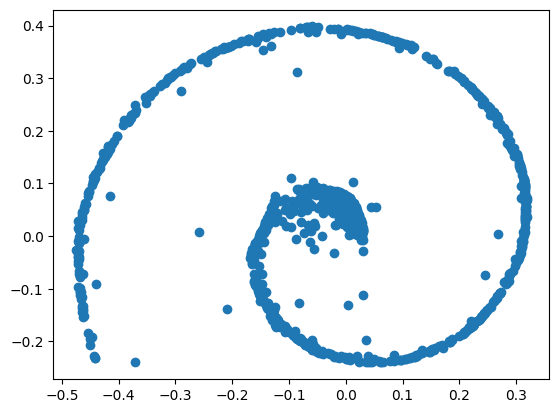

In [4]:
import optax
import stanza.train as st

# The "true" loss computed the gt denoiser
# and a squared error loss
def loss(vars, iterations, rng_key, sample):
    denoiser = lambda rng_key, x, t: model.apply(vars, x, t - 1)
    t_rng, l_rng = jax.random.split(rng_key)
    t = jax.random.randint(t_rng, (), 0, schedule.num_steps) + 1
    x, _, _ = schedule.add_noise(l_rng, sample, t)
    denoised = schedule.compute_denoised(x, t, train_data.tree)
    output = schedule.output_from_denoised(x, t, denoised)
    model_output = denoiser(None, x, t)
    loss = jnp.mean(jnp.square(model_output - output))
    return st.LossOutput(
        loss=loss,
        metrics={"loss": loss}
    )

epochs = 1000
batch_size = 128
iterations = len(train_data) // batch_size * epochs
trained_vars = st.fit(
    batch_loss_fn=st.batch_loss(loss),
    data=train_data,
    optimizer=optax.adam(optax.cosine_decay_schedule(1e-3, iterations)),
    rng_key=jax.random.PRNGKey(42),
    max_epochs=epochs,
    init_vars=vars,
    batch_size=batch_size,
    hooks=[st.every_n_epochs(50,
        st.console_logger(prefix="train.", metrics=True)
    )]
)
trained_model = lambda rng_key, x, t: model.apply(trained_vars, x, t - 1)
def sample(rng_key):
    return schedule.sample(rng_key, trained_model, train_data[0], trajectory=True)
samples, sample_trajs = jax.vmap(sample)(jax.random.split(jax.random.PRNGKey(42), 1024))
plt.clf()
plt.scatter(samples[:,0], samples[:,1])
plt.show()